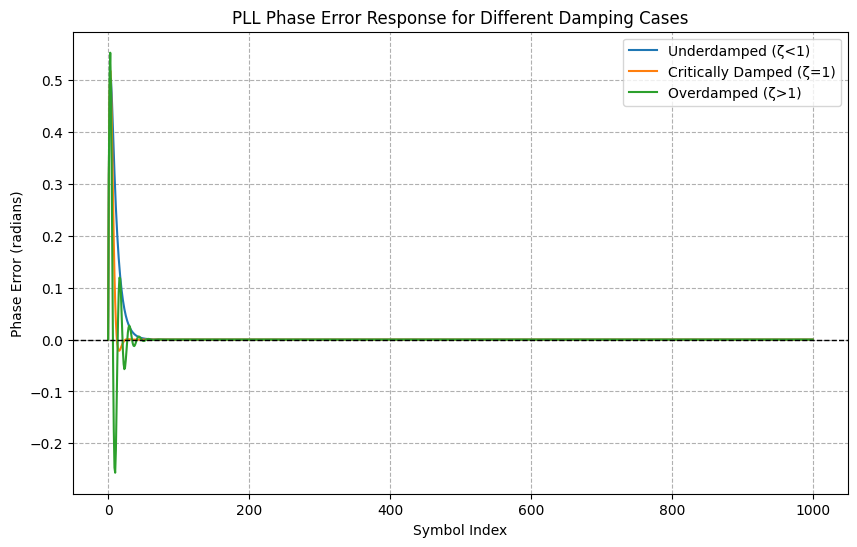

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
n_samples = 1000  # Number of symbols
freq_offset = 0.05  # Simulated frequency offset (arbitrary small value)
phase_offset = 0  # Initial phase offset

# Define a simple QPSK constellation for visualization
symbols = np.array([1+1j, 1-1j, -1+1j, -1-1j])

# symbols = np.array([1+1j, 1-1j, -1+1j, -1-1j,
#                     1+3j, 1-3j, -1+3j, -1-3j,
#                     3+1j, 3-1j, -3+1j, -3-1j,
#                     3+3j, 3-3j, -3+3j, -3-3j,
#                     ])

# Generate random transmitted symbols
np.random.seed(42)
random_indices = np.random.randint(0, len(symbols), n_samples)
tx_symbols = symbols[random_indices]

# Apply frequency and phase offset
n = np.arange(n_samples)
rx_symbols = tx_symbols * np.exp(1j * (2 * np.pi * freq_offset * n + phase_offset))

# Define PLL parameter sets for underdamped, critically damped, and overdamped cases
pll_configs = {
    "Underdamped (ζ<1)": {"Kp": 0.5, "Ki": 0.05},
    "Critically Damped (ζ=1)": {"Kp": 0.4, "Ki": 0.1},
    "Overdamped (ζ>1)": {"Kp": 0.2, "Ki": 0.2}
}

# Run the PLL for each configuration
plt.figure(figsize=(10, 6))

for label, params in pll_configs.items():
    Kp, Ki = params["Kp"], params["Ki"]
    phase_nco = 0  # Initial phase of NCO
    freq_nco = 0   # Initial frequency estimate
    integrator = 0  # Integral term accumulator
    phase_errors = np.zeros(n_samples)

    for i in range(n_samples):
        # NCO Phase Correction
        corrected_symbol = rx_symbols[i] * np.exp(-1j * phase_nco)

        # Decision-directed phase error (assuming nearest symbol is the transmitted one)
        closest_symbol = symbols[np.argmin(abs(symbols - corrected_symbol))]
        phase_error = np.angle(corrected_symbol * np.conj(closest_symbol))
        phase_errors[i] = phase_error

        # PI loop filter
        integrator += Ki * phase_error  # Integral term
        freq_nco = Kp * phase_error + integrator  # Proportional + Integral control

        # NCO phase update
        phase_nco += freq_nco  # Accumulate frequency to update phase

    # Plot phase error response
    plt.plot(range(n_samples), phase_errors, label=label)

# Final plot formatting
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.xlabel("Symbol Index")
plt.ylabel("Phase Error (radians)")
plt.title("PLL Phase Error Response for Different Damping Cases")
plt.legend()
plt.grid(True, linestyle="--")
plt.show()
